# Data Preprocessing

In [1]:
# Important libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import csv
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

# File paths
fp_notebooks_folder = "./"
fp_code_folder = "../"
fp_processed_folder = os.path.join(fp_code_folder, "../processed_data")
fp_converted_folder = os.path.join(fp_processed_folder, "converted_to_csv")
fp_downsampled_folder = os.path.join(fp_processed_folder, "downsampled")
fp_downsampled_continuous_file = os.path.join(fp_downsampled_folder, "continous.csv")
fp_downsampled_continuous_ae_file = os.path.join(fp_downsampled_folder, "continous_ae.csv")
fp_downsampled_dropna_file = os.path.join(fp_downsampled_folder, "dropna.csv")
fp_fields_file = os.path.join(fp_converted_folder, "fields.csv")

In [2]:
# Get fields file to analyse
fields_df = pd.read_csv(fp_fields_file, quoting=csv.QUOTE_NONE, escapechar='/', index_col=0)
fields_df

,fs,sig_len,n_sig,base_date,base_time,units,sig_name,comments,unique_alarms,record
0,0.976562,51138,7,1994-12-13,08:38:53,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'*ASYSTOLE': 23, '*TACHY 216 > 180': 9, '*VEN...",048n
1,0.976562,77038,7,1995-02-22,13:08:55,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'ABP 184 > 180': 115, 'ABP 182 > 180': 115,...",052n
2,0.976562,141796,7,1995-02-24,09:44:42,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'PAIR VPBs': 982, 'HR 53 < 55': 560, 'MULTI...",054n
3,0.976562,131250,12,1995-03-02,15:36:24,"['mmHg', 'mmHg', 'mmHg', 'lpm', 'bpm', 'mmHg',...","['ABPmean', 'ABPsys', 'ABPdias', 'C.O.', 'HR',...",[],"{'VPBs > 5/MIN': 1661, 'PAIR VPBs': 1584, 'MUL...",055n
4,0.976562,4606,5,1995-01-24,08:22:11,"['mmHg', 'mmHg', 'mmHg', 'bpm', '%']","['NBPmean', 'NBPsys', 'NBPdias', 'RESP', 'SpO2']",[],{'MULTIFORM VPBs': 4600},208n
...,...,...,...,...,...,...,...,...,...,...
111,0.976562,151176,14,1996-04-06,15:26:26,"['mmHg', 'mmHg', 'mmHg', 'lpm', 'mmHg', 'bpm',...","['ABPmean', 'ABPsys', 'ABPdias', 'C.O.', 'CVP'...",[],"{'VPBs > 5/MIN': 20341, 'VPBs > 11/MIN': 1085,...",482n
112,0.976562,147656,15,1996-04-22,17:35:49,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'lpm', 'mmHg',...","['ABPmean', 'ABPsys', 'ABPdias', 'AWRR', 'C.O....",[],"{'IRREGULAR HR': 19031, 'MULTIFORM VPBs': 1982...",484n
113,0.976562,154687,12,1996-04-29,14:48:52,"['mmHg', 'mmHg', 'mmHg', 'lpm', 'mmHg', 'bpm',...","['ABPmean', 'ABPsys', 'ABPdias', 'C.O.', 'CVP'...",[],"{'PAIR VPBs': 731, 'VPBs > 11/MIN': 567, 'IRRE...",485n
114,0.976562,193946,18,1996-05-02,11:54:49,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'lpm', 'mmHg',...","['ABPmean', 'ABPsys', 'ABPdias', 'AWRR', 'C.O....",[],"{'PAIR VPBs': 4158, 'RUN VPBs 3 - 9': 1688, 'M...",486n


In [3]:
def add_feat_names(fields_df):
    feat_names = []
    for i in range(len(fields_df)):
        row = fields_df.iloc[i]
        units_list, sig_list = eval(row["units"]), eval(row["sig_name"])
        cur_feat_names = {sig_list[j] + " (" + units_list[j] + ")" for j in range(len(units_list))}
        feat_names.append(cur_feat_names)
    return feat_names

fields_df["feat_cols"] = add_feat_names(fields_df)
fields_df

,fs,sig_len,n_sig,base_date,base_time,units,sig_name,comments,unique_alarms,record,feat_cols
0,0.976562,51138,7,1994-12-13,08:38:53,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'*ASYSTOLE': 23, '*TACHY 216 > 180': 9, '*VEN...",048n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
1,0.976562,77038,7,1995-02-22,13:08:55,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'ABP 184 > 180': 115, 'ABP 182 > 180': 115,...",052n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
2,0.976562,141796,7,1995-02-24,09:44:42,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'PAIR VPBs': 982, 'HR 53 < 55': 560, 'MULTI...",054n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
3,0.976562,131250,12,1995-03-02,15:36:24,"['mmHg', 'mmHg', 'mmHg', 'lpm', 'bpm', 'mmHg',...","['ABPmean', 'ABPsys', 'ABPdias', 'C.O.', 'HR',...",[],"{'VPBs > 5/MIN': 1661, 'PAIR VPBs': 1584, 'MUL...",055n,"{PAPmean (mmHg), PAPdias (mmHg), ABPsys (mmHg)..."
4,0.976562,4606,5,1995-01-24,08:22:11,"['mmHg', 'mmHg', 'mmHg', 'bpm', '%']","['NBPmean', 'NBPsys', 'NBPdias', 'RESP', 'SpO2']",[],{'MULTIFORM VPBs': 4600},208n,"{SpO2 (%), RESP (bpm), NBPsys (mmHg), NBPdias ..."
...,...,...,...,...,...,...,...,...,...,...,...
111,0.976562,151176,14,1996-04-06,15:26:26,"['mmHg', 'mmHg', 'mmHg', 'lpm', 'mmHg', 'bpm',...","['ABPmean', 'ABPsys', 'ABPdias', 'C.O.', 'CVP'...",[],"{'VPBs > 5/MIN': 20341, 'VPBs > 11/MIN': 1085,...",482n,"{ST1 (mV), PAPmean (mmHg), PAPdias (mmHg), ST2..."
112,0.976562,147656,15,1996-04-22,17:35:49,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'lpm', 'mmHg',...","['ABPmean', 'ABPsys', 'ABPdias', 'AWRR', 'C.O....",[],"{'IRREGULAR HR': 19031, 'MULTIFORM VPBs': 1982...",484n,"{AWRR (bpm), PAPmean (mmHg), PAPdias (mmHg), A..."
113,0.976562,154687,12,1996-04-29,14:48:52,"['mmHg', 'mmHg', 'mmHg', 'lpm', 'mmHg', 'bpm',...","['ABPmean', 'ABPsys', 'ABPdias', 'C.O.', 'CVP'...",[],"{'PAIR VPBs': 731, 'VPBs > 11/MIN': 567, 'IRRE...",485n,"{PAPmean (mmHg), PAPdias (mmHg), ABPsys (mmHg)..."
114,0.976562,193946,18,1996-05-02,11:54:49,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'lpm', 'mmHg',...","['ABPmean', 'ABPsys', 'ABPdias', 'AWRR', 'C.O....",[],"{'PAIR VPBs': 4158, 'RUN VPBs 3 - 9': 1688, 'M...",486n,"{AWRR (bpm), ST1 (mV), PAPmean (mmHg), PAPdias..."


## Select Feature Set

In [4]:
# Check what are the most common subset of features
def most_comment_subset_of_features(fields_df):
    feat_set_series = fields_df["feat_cols"]
    feat_set_counts = feat_set_series.value_counts().reset_index()
    feat_set_counts.columns = ["feat_set", "count"]
    feat_set_counts["num_features"] = [len(feat_set) for feat_set in feat_set_counts["feat_set"]]
    feat_set_counts = feat_set_counts.sort_values("num_features", ascending=True)
    num_unique_feat_sets = len(feat_set_counts)
    
    feat_set_inc_list = []
    for i in range(num_unique_feat_sets):
        total_count = 0
        potential_subset = feat_set_counts["feat_set"].iloc[i]
        for j in range(i,num_unique_feat_sets):
            potential_superset, count = feat_set_counts[["feat_set","count"]].iloc[j].values
            if potential_subset.issubset(potential_superset):
                total_count += count
        feat_set_inc_list.append({"feat_set": potential_subset, "inc_count": total_count})
    
    feat_set_inc_df = pd.DataFrame(feat_set_inc_list)
    
    return feat_set_counts, feat_set_inc_df.sort_values("inc_count", ascending=False)
feat_set_stats = most_comment_subset_of_features(fields_df)
display(feat_set_stats[0])
display(feat_set_stats[1])

,feat_set,count,num_features
39,{RESP (bpm)},1,1
1,"{SpO2 (%), RESP (bpm)}",12,2
35,"{C.O. (lpm), SpO2 (%), Tblood (degC)}",1,3
4,"{C.O. (lpm), SpO2 (%), Tblood (degC), RESP (bpm)}",6,4
32,"{AWRR (bpm), SpO2 (%), ETCO2 (mmHg), RESP (bpm...",1,5
5,"{SpO2 (%), RESP (bpm), NBPsys (mmHg), NBPdias ...",4,5
10,"{PAWP (mmHg), SpO2 (%), Tblood (degC), RESP (b...",2,5
16,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)...",2,6
40,"{HR (bpm), RESP (bpm), NBPsys (mmHg), NBPdias ...",1,6
14,"{SpO2 (%), HR (bpm), RESP (bpm), NBPsys (mmHg)...",2,7


,feat_set,inc_count
0,{RESP (bpm)},90
1,"{SpO2 (%), RESP (bpm)}",88
7,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)...",57
11,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)...",48
2,"{C.O. (lpm), SpO2 (%), Tblood (degC)}",37
16,"{PAPmean (mmHg), PAPdias (mmHg), ABPsys (mmHg)...",35
5,"{SpO2 (%), RESP (bpm), NBPsys (mmHg), NBPdias ...",32
20,"{PAPmean (mmHg), PAPdias (mmHg), ABPsys (mmHg)...",27
8,"{HR (bpm), RESP (bpm), NBPsys (mmHg), NBPdias ...",24
9,"{SpO2 (%), HR (bpm), RESP (bpm), NBPsys (mmHg)...",23


In [5]:
feat_set = feat_set_stats[1].iloc[2][0]
# Check above count
def check_feat_set_count(fields_df, cur_feat_set):
    feat_set_series = fields_df["feat_cols"]
    count = 0
    for fs in feat_set_series:
        if cur_feat_set.issubset(fs):
            count += 1
    return count
check_feat_set_count(fields_df, cur_feat_set=feat_set)

57

In [6]:
# Shortlist patients with feat_set
def shortlist_patients_with_feat_set(fields_df, cur_feat_set):
    feat_set_series = fields_df["feat_cols"]
    records = []
    for i, fs in enumerate(feat_set_series):
        if cur_feat_set.issubset(fs):
            records.append(fields_df["record"].iloc[i])
    return records
shortlisted_records = shortlist_patients_with_feat_set(fields_df, cur_feat_set=feat_set)
print(len(shortlisted_records), "Records:", shortlisted_records)

57 Records: ['048n', '052n', '054n', '055n', '211n', '212n', '213n', '214n', '216n', '220n', '221n', '226n', '230n', '231n', '232n', '235n', '237n', '240n', '241n', '242n', '243n', '245n', '248n', '252n', '253n', '254n', '259n', '260n', '264n', '267n', '268n', '269n', '271n', '291n', '293n', '401n', '403n', '408n', '409n', '413n', '414n', '415n', '417n', '418n', '427n', '442n', '449n', '455n', '457n', '464n', '465n', '466n', '467n', '471n', '472n', '474n', '476n']


In [7]:
fields_df_shortlisted = fields_df[fields_df["record"].isin(shortlisted_records)]
fields_df_shortlisted

,fs,sig_len,n_sig,base_date,base_time,units,sig_name,comments,unique_alarms,record,feat_cols
0,0.976562,51138,7,1994-12-13,08:38:53,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'*ASYSTOLE': 23, '*TACHY 216 > 180': 9, '*VEN...",048n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
1,0.976562,77038,7,1995-02-22,13:08:55,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'ABP 184 > 180': 115, 'ABP 182 > 180': 115,...",052n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
2,0.976562,141796,7,1995-02-24,09:44:42,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'PAIR VPBs': 982, 'HR 53 < 55': 560, 'MULTI...",054n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
3,0.976562,131250,12,1995-03-02,15:36:24,"['mmHg', 'mmHg', 'mmHg', 'lpm', 'bpm', 'mmHg',...","['ABPmean', 'ABPsys', 'ABPdias', 'C.O.', 'HR',...",[],"{'VPBs > 5/MIN': 1661, 'PAIR VPBs': 1584, 'MUL...",055n,"{PAPmean (mmHg), PAPdias (mmHg), ABPsys (mmHg)..."
7,0.976562,75991,6,1995-01-26,14:34:07,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', '%']","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'RESP',...",[],"{'PAIR VPBs': 328, 'HR 126 > 120': 99, 'ABP 2...",211n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
8,0.976562,145275,10,1995-04-04,14:00:03,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'mmHg', 'mmHg'...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PAPmea...",[],"{'VPBs > 5/MIN': 11644, 'MISSED BEATS': 10580...",212n,"{PAPmean (mmHg), PAPdias (mmHg), ABPsys (mmHg)..."
9,0.976562,171093,7,1995-04-06,09:17:44,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'VPBs > 5/MIN': 3536, 'ABP 87 < 90': 717, ...",213n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
10,0.976562,90157,10,1995-04-19,07:14:25,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'mmHg', 'mmHg'...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'NBPmea...",[],"{'RUN VPBs > 2': 3855, 'PAIR VPBs': 2566, 'VEN...",214n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
12,0.976562,95654,16,1995-05-07,14:11:32,"['mmHg', 'mmHg', 'mmHg', 'mmHg', 'mmHg', 'mmHg...","['ABPmean', 'ABPsys', 'ABPdias', 'ARTmean', 'A...",[],"{'VENT TRIGEMINY': 483, 'VPBs > 5/MIN': 389, ...",216n,"{PAPmean (mmHg), ARTmean (mmHg), PAPdias (mmHg..."
15,0.976562,4101,7,1995-05-17,08:26:10,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],{'MULTIFORM VPBs': 309},220n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."


In [8]:
fields_df_shortlisted.head()

,fs,sig_len,n_sig,base_date,base_time,units,sig_name,comments,unique_alarms,record,feat_cols
0,0.976562,51138,7,1994-12-13,08:38:53,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'*ASYSTOLE': 23, '*TACHY 216 > 180': 9, '*VEN...",048n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
1,0.976562,77038,7,1995-02-22,13:08:55,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'ABP 184 > 180': 115, 'ABP 182 > 180': 115,...",052n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
2,0.976562,141796,7,1995-02-24,09:44:42,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'PAIR VPBs': 982, 'HR 53 < 55': 560, 'MULTI...",054n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
3,0.976562,131250,12,1995-03-02,15:36:24,"['mmHg', 'mmHg', 'mmHg', 'lpm', 'bpm', 'mmHg',...","['ABPmean', 'ABPsys', 'ABPdias', 'C.O.', 'HR',...",[],"{'VPBs > 5/MIN': 1661, 'PAIR VPBs': 1584, 'MUL...",055n,"{PAPmean (mmHg), PAPdias (mmHg), ABPsys (mmHg)..."
7,0.976562,75991,6,1995-01-26,14:34:07,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', '%']","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'RESP',...",[],"{'PAIR VPBs': 328, 'HR 126 > 120': 99, 'ABP 2...",211n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."


## Select Alarms to Predict

In [9]:
def most_common_alarms(fields_df_shortlisted):
    alarm_col = fields_df_shortlisted["unique_alarms"]
    alarm_count = {}
    num_shortlisted = len(fields_df_shortlisted)
    for i in range(num_shortlisted):
        unique_alarms_dict = eval(alarm_col.iloc[i])
        for alarm, count in unique_alarms_dict.items():
            alarm = alarm.strip()
            if alarm in alarm_count:
                alarm_count[alarm] += count
            else:
                alarm_count[alarm] = count
    alarm_series = pd.Series(alarm_count).sort_values(ascending=False).reset_index()
    alarm_series["index"] = alarm_series["index"]
    alarm_series.columns = ["alarms", "count"]
    return alarm_series

alarm_count = most_common_alarms(fields_df_shortlisted)
alarm_count.head(10)

,alarms,count
0,PAIR VPBs,165344
1,MULTIFORM VPBs,159343
2,IRREGULAR HR,96848
3,VPBs > 5/MIN,95106
4,VPBs > 8/MIN,94262
5,MISSED BEATS,61802
6,RUN VPBs > 2,47527
7,VENT RHYTHM,10349
8,*VENT TACHY,10286
9,R-ON-T VPBs,7655


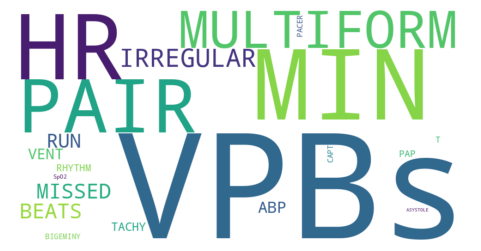

In [10]:
# Show word cloud of alarms
def generate_alarm_wordcloud(alarm_count):
    text = " ".join(alarm for alarm, count in alarm_count[["alarms", "count"]].values for j in range(count))
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
        width=1000, height=500, stopwords=stopwords, background_color="white", collocations=False, max_words=20).generate(text)
    plt.figure(figsize=(6,3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
generate_alarm_wordcloud(alarm_count)

In [11]:
# find out how many alarms with "VPB" in it
def query_alarm_count(alarm_count, keyword):
    alarm_list = []
    total_count = 0
    for alarm, count in alarm_count[["alarms", "count"]].values:
        if keyword in alarm:
            alarm_list.append(alarm)
            total_count += count 
    return alarm_count[alarm_count["alarms"].isin(alarm_list)], total_count
vpb_alarm_stats = query_alarm_count(alarm_count, keyword="VPB")
print(vpb_alarm_stats[1], "VPBs:")
display(vpb_alarm_stats[0])

584358 VPBs:


,alarms,count
0,PAIR VPBs,165344
1,MULTIFORM VPBs,159343
3,VPBs > 5/MIN,95106
4,VPBs > 8/MIN,94262
6,RUN VPBs > 2,47527
9,R-ON-T VPBs,7655
10,VPBs > 5/MIN,6642
14,RUN VPBs 3 - 9,4397
22,VPBs > 11/MIN,2172
24,RUN VPBs > 5,1900


In [12]:
# How many patients have vpb
def query_records_with_alarm_keyword(fields_df_shortlisted, keyword_list):
    df_list = []
    for keyword in keyword_list:
        count = 0
        record_list = []
        for record, alarm_str in fields_df_shortlisted[["record","unique_alarms"]].values:
            if keyword in alarm_str:
                count += 1
                record_list.append(record)
        df_list.append({"keyword": keyword, "count":count, "records": record_list})
    return pd.DataFrame(df_list)
vbp_record_stats = query_records_with_alarm_keyword(fields_df_shortlisted, keyword_list=["VPB"]+vpb_alarm_stats[0]["alarms"].tolist())
vbp_record_stats

,keyword,count,records
0,VPB,49,"[048n, 054n, 055n, 211n, 212n, 213n, 214n, 216..."
1,PAIR VPBs,39,"[048n, 054n, 055n, 211n, 213n, 214n, 216n, 221..."
2,MULTIFORM VPBs,33,"[054n, 055n, 213n, 214n, 220n, 221n, 226n, 230..."
3,VPBs > 5/MIN,26,"[211n, 212n, 213n, 214n, 216n, 230n, 231n, 232..."
4,VPBs > 8/MIN,1,[264n]
5,RUN VPBs > 2,22,"[212n, 213n, 214n, 230n, 232n, 235n, 237n, 240..."
6,R-ON-T VPBs,13,"[214n, 232n, 245n, 252n, 253n, 259n, 260n, 418..."
7,VPBs > 5/MIN,7,"[055n, 226n, 408n, 409n, 442n, 457n, 472n]"
8,RUN VPBs 3 - 9,9,"[048n, 055n, 226n, 408n, 442n, 455n, 457n, 472..."
9,VPBs > 11/MIN,3,"[409n, 457n, 472n]"


In [13]:
# Shortlist patients with alarm
def shortlist_patients_with_alarm(vbp_record_stats, keyword):
    record_list = vbp_record_stats[vbp_record_stats["keyword"]==keyword]["records"][0]
    return record_list
shortlisted_records_alarm = shortlist_patients_with_alarm(vbp_record_stats, keyword="VPB")
fields_df_shortlisted_alarm = fields_df_shortlisted[fields_df_shortlisted["record"].isin(shortlisted_records_alarm)]
display(fields_df_shortlisted_alarm.head())
print(fields_df_shortlisted_alarm.shape)

,fs,sig_len,n_sig,base_date,base_time,units,sig_name,comments,unique_alarms,record,feat_cols
0,0.976562,51138,7,1994-12-13,08:38:53,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'*ASYSTOLE': 23, '*TACHY 216 > 180': 9, '*VEN...",048n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
2,0.976562,141796,7,1995-02-24,09:44:42,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', 'bpm', ...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PULSE'...",[],"{'PAIR VPBs': 982, 'HR 53 < 55': 560, 'MULTI...",054n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
3,0.976562,131250,12,1995-03-02,15:36:24,"['mmHg', 'mmHg', 'mmHg', 'lpm', 'bpm', 'mmHg',...","['ABPmean', 'ABPsys', 'ABPdias', 'C.O.', 'HR',...",[],"{'VPBs > 5/MIN': 1661, 'PAIR VPBs': 1584, 'MUL...",055n,"{PAPmean (mmHg), PAPdias (mmHg), ABPsys (mmHg)..."
7,0.976562,75991,6,1995-01-26,14:34:07,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'bpm', '%']","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'RESP',...",[],"{'PAIR VPBs': 328, 'HR 126 > 120': 99, 'ABP 2...",211n,"{ABPsys (mmHg), SpO2 (%), HR (bpm), RESP (bpm)..."
8,0.976562,145275,10,1995-04-04,14:00:03,"['mmHg', 'mmHg', 'mmHg', 'bpm', 'mmHg', 'mmHg'...","['ABPmean', 'ABPsys', 'ABPdias', 'HR', 'PAPmea...",[],"{'VPBs > 5/MIN': 11644, 'MISSED BEATS': 10580...",212n,"{PAPmean (mmHg), PAPdias (mmHg), ABPsys (mmHg)..."


(49, 11)


In [14]:
# 6.22 million rows in total (with nan values)
fields_df_shortlisted_alarm["sig_len"].sum() 

6227307

## Split Records into Train, Valid, Test Records

In [15]:
# split records by train, valid, test
def recordwise_train_valid_test_split(df, valid_prop, test_prop, seed):
    records = df["record"].unique()
    num_records = len(records)
    record_indices = np.arange(num_records)
    np.random.seed(seed=seed)
    np.random.shuffle(record_indices)
    shuffled_records = records[record_indices]
    num_valid, num_test = round(valid_prop * num_records), round(test_prop * num_records)
    num_train = num_records - num_valid - num_test
    train_records, valid_records, test_records = (
        shuffled_records[:num_train], shuffled_records[num_train: num_train+num_valid],
        shuffled_records[num_train+num_valid:num_train+num_valid+num_test],
    )
    return train_records, valid_records, test_records

train_records, valid_records, test_records = recordwise_train_valid_test_split(
    fields_df_shortlisted, valid_prop=0.1, test_prop=0.2, seed=2023)

In [16]:
print(len(train_records), "Train Records:", train_records)
print(len(valid_records), "Valid Records:", valid_records)
print(len(test_records), "Test Records:", test_records)

40 Train Records: ['474n' '269n' '241n' '232n' '230n' '242n' '221n' '048n' '220n' '415n'
 '418n' '403n' '226n' '259n' '268n' '401n' '464n' '260n' '476n' '237n'
 '471n' '427n' '054n' '243n' '442n' '414n' '245n' '455n' '409n' '052n'
 '211n' '293n' '216n' '417n' '235n' '472n' '267n' '457n' '214n' '449n']
6 Valid Records: ['467n' '466n' '253n' '212n' '413n' '231n']
11 Test Records: ['240n' '465n' '271n' '408n' '248n' '055n' '264n' '291n' '213n' '254n'
 '252n']


## Downsample Time Series Data

In [17]:
feat_set

{'ABPdias (mmHg)',
 'ABPmean (mmHg)',
 'ABPsys (mmHg)',
 'HR (bpm)',
 'RESP (bpm)',
 'SpO2 (%)'}

In [18]:
i, j = np.ogrid[:6, :4]
x = 10*i + j
x.shape

(6, 4)

In [19]:
x

array([[ 0,  1,  2,  3],
       [10, 11, 12, 13],
       [20, 21, 22, 23],
       [30, 31, 32, 33],
       [40, 41, 42, 43],
       [50, 51, 52, 53]])

In [20]:
window = 2
v = x.reshape(x.shape[0]//window, window, x.shape[1])
v

array([[[ 0,  1,  2,  3],
        [10, 11, 12, 13]],

       [[20, 21, 22, 23],
        [30, 31, 32, 33]],

       [[40, 41, 42, 43],
        [50, 51, 52, 53]]])

In [21]:
v = v.astype('float')
v[v == 31] = np.NAN
v

array([[[ 0.,  1.,  2.,  3.],
        [10., 11., 12., 13.]],

       [[20., 21., 22., 23.],
        [30., nan, 32., 33.]],

       [[40., 41., 42., 43.],
        [50., 51., 52., 53.]]])

In [22]:
np.where(~np.isnan(v).any(axis=(1,2)))[0]

array([0, 2])

In [23]:
print(np.isnan(v).any(axis=(1,2)))
np.isnan(v).any(axis=(1,2)).shape

[False  True False]


(3,)

In [24]:
v[~np.isnan(v).any(axis=(1,2)), :, :]

array([[[ 0.,  1.,  2.,  3.],
        [10., 11., 12., 13.]],

       [[40., 41., 42., 43.],
        [50., 51., 52., 53.]]])

  0%|                                                    | 0/57 [00:00<?, ?it/s]/tmp/ipykernel_19560/100648602.py:110: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp_csv, index_col=0)
  4%|█▌                                          | 2/57 [00:00<00:04, 11.84it/s]/tmp/ipykernel_19560/100648602.py:110: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp_csv, index_col=0)
 21%|█████████                                  | 12/57 [00:02<00:07,  6.05it/s]/tmp/ipykernel_19560/100648602.py:110: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp_csv, index_col=0)
 23%|█████████▊                                 | 13/57 [00:02<00:07,  6.07it/s]/tmp/ipykernel_19560/100648602.py:110: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
 

Flattening train, valid and all
(95055, 60, 6) 95055 95055
Epoch 1/300
239/239 [==============================] - 4s 9ms/step - loss: 7188.9658 - val_loss: 6379.4600
Epoch 2/300
239/239 [==============================] - 2s 10ms/step - loss: 6667.8091 - val_loss: 5953.0186
Epoch 3/300
239/239 [==============================] - 2s 9ms/step - loss: 6241.1138 - val_loss: 5554.2793
Epoch 4/300
239/239 [==============================] - 2s 10ms/step - loss: 5836.8115 - val_loss: 5175.8184
Epoch 5/300
239/239 [==============================] - 2s 9ms/step - loss: 5451.6953 - val_loss: 4816.3164
Epoch 6/300
239/239 [==============================] - 2s 9ms/step - loss: 5084.4868 - val_loss: 4475.0161
Epoch 7/300
239/239 [==============================] - 2s 9ms/step - loss: 4735.1030 - val_loss: 4151.2876
Epoch 8/300
239/239 [==============================] - 2s 9ms/step - loss: 4402.3877 - val_loss: 3844.5591
Epoch 9/300
239/239 [==============================] - 2s 8ms/step - loss: 4086.079

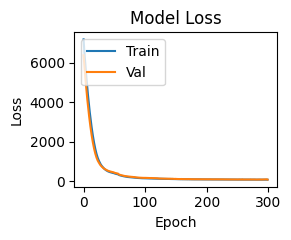

,AE_Feature0,AE_Feature1,AE_Feature2,AE_Feature3,AE_Feature4,AE_Feature5,AE_Feature6,AE_Feature7,AE_Feature8,AE_Feature9,AE_Feature10,AE_Feature11,Alarm,Record Indices,Record
0,1.0,-0.553978,7.811709e-37,-1.0,-1.0,1.0,-0.636699,-3.986612e-33,0.412269,-0.876002,1.393308e-02,0.761594,{},0,048n
1,1.0,-0.630717,9.631055e-37,-1.0,-1.0,1.0,-0.547311,-1.951047e-32,0.412090,-0.815063,4.305582e-10,0.761594,{},1,048n
2,1.0,-0.602088,2.932477e-36,-1.0,-1.0,1.0,-0.568048,-6.168263e-32,0.413634,-0.814214,5.095492e-12,0.761594,{},2,048n
3,1.0,-0.497812,1.546862e-36,-1.0,-1.0,1.0,-0.528529,-6.526549e-34,0.417583,-0.808470,3.942474e-12,0.761594,{},3,048n
4,1.0,-0.563691,3.053826e-38,-1.0,-1.0,1.0,-0.386452,-5.116531e-36,0.403645,-0.775938,6.311921e-12,0.761594,{},4,048n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95050,1.0,-0.730082,2.343728e-38,-1.0,-1.0,1.0,-0.602731,-7.549574e-32,0.383852,-0.729673,2.414565e-14,0.761594,{},934,476n
95051,1.0,-0.809049,0.000000e+00,-1.0,-1.0,1.0,-0.597443,-8.406037e-34,0.307347,-0.723341,1.815060e-14,0.761594,{},935,476n
95052,1.0,-0.759448,2.730138e-38,-1.0,-1.0,1.0,-0.598009,-2.879352e-31,0.351184,-0.717634,1.630146e-15,0.761594,{},936,476n
95053,1.0,-0.778761,0.000000e+00,-1.0,-1.0,1.0,-0.601249,-2.357877e-32,0.361242,-0.709648,3.075314e-15,0.761594,{},937,476n


In [29]:
def downsample_all_csvs(fp_converted_folder, feat_set, fields_df_shortlisted, downsample_function, window=60):
    df_list = []
    records = fields_df_shortlisted["record"].tolist()
    for record in tqdm(records):
        fp_csv = os.path.join(fp_converted_folder, record+".csv")
        df = pd.read_csv(fp_csv, index_col=0)
        df = downsample_function(df, window, feat_set, record)
        df["record"] = record
        df_list.append(df)
    all_df = pd.concat(df_list).reset_index()
    all_df.columns = ["record_index"] + all_df.columns[1:].to_list()
    return all_df

def downsample_ts(df, window, feat_set, alarm_col="alarms"):
    df[alarm_col] = df[alarm_col].str.strip()
    feat_set = list(feat_set)
    all_feat = feat_set + [alarm_col]
    df_feat_sel = df[all_feat]
    grouped = df_feat_sel.groupby((df_feat_sel.index/window).astype('i'))
    df_downsampled = grouped[feat_set].mean()
    alarm_list = []
    for group, alarms in grouped[alarm_col]:
        list_of_alarms = [eval(al) for al in alarms[alarms.notna()]]
        alarm_set = set().union(*list_of_alarms)
        alarm_list.append(alarm_set)
    df_downsampled["alarms"] = alarm_list
    return df_downsampled

def downsample_ts_withstd(df, window, feat_set, alarm_col="alarms"):
    df[alarm_col] = df[alarm_col].str.strip()
    feat_set = list(feat_set)
    all_feat = feat_set + [alarm_col]
    df_feat_sel = df[all_feat]
    grouped = df_feat_sel.groupby((df_feat_sel.index/window).astype('i'))
    
    # Downsample variables
    df_downsampled = grouped[feat_set].mean()
    df_downsampled.columns = [col + "_mean" for col in feat_set]
    std_cols = [col + "_std" for col in feat_set]
    df_downsampled[std_cols] = grouped[feat_set].std()
    
    # Aggregate alarms
    alarm_list = []
    for group, alarms in grouped[alarm_col]:
        list_of_alarms = [eval(al) for al in alarms[alarms.notna()]]
        alarm_set = set().union(*list_of_alarms)
        alarm_list.append(alarm_set)
    df_downsampled["alarms"] = alarm_list
    return df_downsampled

def set_seed(seed):
    import tensorflow as tf
    import random
    tf.config.experimental.enable_op_determinism()
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def display_history(history, show_acc=False):
    if show_acc:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 2.5))
        axes[0].plot(history.history['loss'])
        axes[0].plot(history.history['val_loss'])
        axes[0].set_title('Model Loss')
        axes[0].set_ylabel('Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Val'], loc='upper left')
        axes[1].plot(history.history['accuracy'])
        axes[1].plot(history.history['val_accuracy'])
        axes[1].set_title('Model Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Val'], loc='upper left')
        axes[2].plot(history.history['f1_score'])
        axes[2].plot(history.history['val_f1_score'])
        axes[2].set_title('Model F1 Score')
        axes[2].set_ylabel('F1 Score')
        axes[2].set_xlabel('Epoch')
        axes[2].legend(['Train', 'Val'], loc='upper left')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.5))
        axes.plot(history.history['loss'])
        axes.plot(history.history['val_loss'])
        axes.set_title('Model Loss')
        axes.set_ylabel('Loss')
        axes.set_xlabel('Epoch')
        axes.legend(['Train', 'Val'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
def downsample_all_autoencoder(fp_converted_folder, feat_set, fields_df_shortlisted, alarm_col, window=60):
#     def rolling_df(df, feat_set, window):
#         mat = df[feat_set].values
#         num_feat = len(feat_set)
#         shape = (window, num_feat)
#         mat_rolled = np.lib.stride_tricks.sliding_window_view(mat, shape)
#         mat_rolled = np.squeeze(mat_rolled, axis=1)
#         return mat_rolled
    
    feat_set = list(feat_set)
    mat_list = []
    records = fields_df_shortlisted["record"].tolist()
    record_all = []
    alarm_all = []
    record_indices_all = []
    for record in tqdm(records):
        fp_csv = os.path.join(fp_converted_folder, record+".csv")
        df = pd.read_csv(fp_csv, index_col=0)
        df = df.reset_index()
        mat = df[feat_set].values
        new_length  = mat.shape[0]//window
        max_mat_size = new_length*window
        mat = mat[:max_mat_size,:]
        cur_mat = mat.reshape(new_length, window, mat.shape[1])
        notnan_mask = ~np.isnan(cur_mat).any(axis=(1,2))
        retained_indices = np.where(notnan_mask)[0]
        record_indices_all.extend(list(retained_indices))
        # remove nan
        cur_mat = cur_mat[notnan_mask, :, :]
        
        short_df = df.iloc[:max_mat_size,:]
        grouped = short_df.groupby(
            (short_df.index//window).astype('i'))
        # Aggregate alarms
        alarm_list = []
        for group, alarms in grouped[alarm_col]:
            if notnan_mask[group]:
                list_of_alarms = [eval(al) for al in alarms[alarms.notna()]]
                alarm_set = set().union(*list_of_alarms)
                alarm_list.append(alarm_set)
        
#         df = downsample_function(df, window, feat_set, record)
        record_all.extend([record for i in range(len(cur_mat))])
        mat_list.append(cur_mat)
        alarm_all.extend(alarm_list)
    sequence_all = np.vstack(mat_list)
    
    print("Flattening train, valid and all")
    print(sequence_all.shape, len(record_all), len(alarm_all))
    sequence_train = sequence_all[pd.Series(record_all).isin(train_records)]
    sequence_valid = sequence_all[pd.Series(record_all).isin(valid_records)]
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
    from tensorflow.keras.callbacks import EarlyStopping
    from  tensorflow.keras.optimizers import Adam
    set_seed(2023)
    num_feats = len(feat_set)
    width, output = num_feats*2, num_feats
    # define model
    model = Sequential()
    model.add(LSTM(width, input_shape=(window, num_feats)))
    model.add(RepeatVector(window))
    model.add(LSTM(width, return_sequences=True))
    model.add(TimeDistributed(Dense(output)))
    ADAM =Adam(clipnorm=1.)
    model.compile(optimizer=ADAM, loss='mse')
    print(model.layers[0])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
    history = model.fit(
        sequence_train, sequence_train, epochs=300,
        validation_data=(sequence_valid, sequence_valid),
        verbose=1,
        batch_size=256,
        callbacks=[es]
    )
    
    display_history(history, show_acc=False)
    
    from keras import backend as K
    get_encoder_layer_output = K.function([model.layers[0].input],
                                      [model.layers[0].output])
    pred_x = get_encoder_layer_output(sequence_all)[0]
    
    df = pd.DataFrame(pred_x, columns=[f"AE_Feature{i}" for i in range(num_feats*2)])
    df["Alarm"] = alarm_all
    df["Record Indices"] = record_indices_all 
    df["Record"] = record_all
    
    return df, model
              


# df_ds = downsample_all_csvs(
#     fp_converted_folder, feat_set, fields_df_shortlisted,  downsample_ts_withstd, window=60)
# df_ds

df_ds, model = downsample_all_autoencoder(fp_converted_folder, feat_set, fields_df_shortlisted, alarm_col="alarms", window=60)
df_ds

In [30]:
df_ds[3891-5:3891+5]

,AE_Feature0,AE_Feature1,AE_Feature2,AE_Feature3,AE_Feature4,AE_Feature5,AE_Feature6,AE_Feature7,AE_Feature8,AE_Feature9,AE_Feature10,AE_Feature11,Alarm,Record Indices,Record
3886,1.000000,-0.432015,9.599314e-38,-1.000000e+00,-1.0,1.0,-0.566494,-2.321284e-31,0.601956,-0.773816,2.425038e-07,0.761594,{},154,055n
3887,1.000000,-0.416966,1.160984e-37,-1.000000e+00,-1.0,1.0,-0.563447,-2.602395e-31,0.605950,-0.773464,2.313999e-07,0.761594,{},155,055n
3888,1.000000,-0.412926,2.530840e-37,-1.000000e+00,-1.0,1.0,-0.557473,-6.368979e-31,0.601881,-0.773964,2.351623e-07,0.761594,{},156,055n
3889,1.000000,-0.411116,2.516439e-37,-1.000000e+00,-1.0,1.0,-0.557070,-6.525570e-31,0.600991,-0.774474,2.296653e-07,0.761594,{},157,055n
3890,1.000000,-0.076698,1.346710e-06,-1.000000e+00,-1.0,1.0,-0.565941,-7.603306e-01,0.081598,-0.804973,3.853953e-07,0.761594,{},158,055n
3891,0.761596,-0.909070,0.000000e+00,-7.745986e-18,-1.0,1.0,-0.061160,-2.648454e-43,0.884912,-0.624037,-3.361486e-04,-1.000000,{},225,055n
3892,-0.098754,-0.348133,-8.031733e-09,-2.715811e-12,-1.0,1.0,-0.004720,-6.040785e-03,0.270889,-0.604276,-3.331775e-04,-1.000000,{},226,055n
3893,1.000000,-0.489524,0.000000e+00,-1.000000e+00,-1.0,1.0,-0.945594,-6.152043e-32,0.637384,-0.810515,-7.125346e-03,0.761594,{ABP 0 < 85},227,055n
3894,1.000000,-0.480709,8.024062e-38,-1.000000e+00,-1.0,1.0,-0.656406,-1.280720e-30,0.611021,-0.769727,1.947414e-07,0.761594,{},228,055n
3895,1.000000,-0.486068,8.059573e-38,-1.000000e+00,-1.0,1.0,-0.649082,-2.656761e-30,0.611768,-0.775852,2.149945e-07,0.761594,{},229,055n


In [31]:
model.save('../../models/lstm_autoencoder.keras')

In [32]:
df_ds = df_ds.rename(columns={"Alarm": "alarms", "Record": "record", "Record Indices":"record_index"})

In [33]:
df_ds["alarms"].value_counts()

alarms
{}                                            79912
{PAIR VPBs}                                    2261
{MULTIFORM VPBs}                               2096
{IRREGULAR HR}                                 1549
{VPBs >  8/MIN}                                1494
                                              ...  
{VPBs >  8/MIN, PAP  155 > 80}                    1
{PAP   -6 < 4}                                    1
{PAP    2 < 4, PAP   -6 < 4, PAP   -5 < 4}        1
{PAP  -11 < 4, PAP   -1 < 4, PAP  -12 < 4}        1
{PAP   54 > 40, ABP   55 < 80}                    1
Name: count, Length: 1757, dtype: int64

In [34]:
def label_rows(df_ds, keyword):
    return [(keyword in str(al)) for al in df_ds["alarms"]]
df_ds["VPBs"] = label_rows(df_ds, keyword="VPBs")
df_ds

,AE_Feature0,AE_Feature1,AE_Feature2,AE_Feature3,AE_Feature4,AE_Feature5,AE_Feature6,AE_Feature7,AE_Feature8,AE_Feature9,AE_Feature10,AE_Feature11,alarms,record_index,record,VPBs
0,1.0,-0.553978,7.811709e-37,-1.0,-1.0,1.0,-0.636699,-3.986612e-33,0.412269,-0.876002,1.393308e-02,0.761594,{},0,048n,False
1,1.0,-0.630717,9.631055e-37,-1.0,-1.0,1.0,-0.547311,-1.951047e-32,0.412090,-0.815063,4.305582e-10,0.761594,{},1,048n,False
2,1.0,-0.602088,2.932477e-36,-1.0,-1.0,1.0,-0.568048,-6.168263e-32,0.413634,-0.814214,5.095492e-12,0.761594,{},2,048n,False
3,1.0,-0.497812,1.546862e-36,-1.0,-1.0,1.0,-0.528529,-6.526549e-34,0.417583,-0.808470,3.942474e-12,0.761594,{},3,048n,False
4,1.0,-0.563691,3.053826e-38,-1.0,-1.0,1.0,-0.386452,-5.116531e-36,0.403645,-0.775938,6.311921e-12,0.761594,{},4,048n,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95050,1.0,-0.730082,2.343728e-38,-1.0,-1.0,1.0,-0.602731,-7.549574e-32,0.383852,-0.729673,2.414565e-14,0.761594,{},934,476n,False
95051,1.0,-0.809049,0.000000e+00,-1.0,-1.0,1.0,-0.597443,-8.406037e-34,0.307347,-0.723341,1.815060e-14,0.761594,{},935,476n,False
95052,1.0,-0.759448,2.730138e-38,-1.0,-1.0,1.0,-0.598009,-2.879352e-31,0.351184,-0.717634,1.630146e-15,0.761594,{},936,476n,False
95053,1.0,-0.778761,0.000000e+00,-1.0,-1.0,1.0,-0.601249,-2.357877e-32,0.361242,-0.709648,3.075314e-15,0.761594,{},937,476n,False


In [35]:
df_ds["VPBs"].value_counts()

VPBs
False    86017
True      9038
Name: count, dtype: int64

In [38]:
def label_true_negative(df_ds):
    if type(df_ds["alarms"][0]) == "str":
        return [len(eval(al)) == 0 for al in df_ds["alarms"]]
    else:
        return [len(al) == 0 for al in df_ds["alarms"]]
# label rows with no alarms at all
df_ds["no_alarms"] = label_true_negative(df_ds)
df_ds

,AE_Feature0,AE_Feature1,AE_Feature2,AE_Feature3,AE_Feature4,AE_Feature5,AE_Feature6,AE_Feature7,AE_Feature8,AE_Feature9,AE_Feature10,AE_Feature11,alarms,record_index,record,VPBs,no_alarms
0,1.0,-0.553978,7.811709e-37,-1.0,-1.0,1.0,-0.636699,-3.986612e-33,0.412269,-0.876002,1.393308e-02,0.761594,{},0,048n,False,True
1,1.0,-0.630717,9.631055e-37,-1.0,-1.0,1.0,-0.547311,-1.951047e-32,0.412090,-0.815063,4.305582e-10,0.761594,{},1,048n,False,True
2,1.0,-0.602088,2.932477e-36,-1.0,-1.0,1.0,-0.568048,-6.168263e-32,0.413634,-0.814214,5.095492e-12,0.761594,{},2,048n,False,True
3,1.0,-0.497812,1.546862e-36,-1.0,-1.0,1.0,-0.528529,-6.526549e-34,0.417583,-0.808470,3.942474e-12,0.761594,{},3,048n,False,True
4,1.0,-0.563691,3.053826e-38,-1.0,-1.0,1.0,-0.386452,-5.116531e-36,0.403645,-0.775938,6.311921e-12,0.761594,{},4,048n,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95050,1.0,-0.730082,2.343728e-38,-1.0,-1.0,1.0,-0.602731,-7.549574e-32,0.383852,-0.729673,2.414565e-14,0.761594,{},934,476n,False,True
95051,1.0,-0.809049,0.000000e+00,-1.0,-1.0,1.0,-0.597443,-8.406037e-34,0.307347,-0.723341,1.815060e-14,0.761594,{},935,476n,False,True
95052,1.0,-0.759448,2.730138e-38,-1.0,-1.0,1.0,-0.598009,-2.879352e-31,0.351184,-0.717634,1.630146e-15,0.761594,{},936,476n,False,True
95053,1.0,-0.778761,0.000000e+00,-1.0,-1.0,1.0,-0.601249,-2.357877e-32,0.361242,-0.709648,3.075314e-15,0.761594,{},937,476n,False,True


In [39]:
df_ds["no_alarms"].value_counts()

no_alarms
True     79912
False    15143
Name: count, dtype: int64

In [40]:
if not os.path.exists(fp_downsampled_folder):
    os.makedirs(fp_downsampled_folder)
df_ds.to_csv(fp_downsampled_continuous_ae_file)

In [41]:
df_ds = pd.read_csv(fp_downsampled_continuous_ae_file, index_col=0)
df_ds

,AE_Feature0,AE_Feature1,AE_Feature2,AE_Feature3,AE_Feature4,AE_Feature5,AE_Feature6,AE_Feature7,AE_Feature8,AE_Feature9,AE_Feature10,AE_Feature11,alarms,record_index,record,VPBs,no_alarms
0,1.0,-0.553978,7.811709e-37,-1.0,-1.0,1.0,-0.636699,-3.986612e-33,0.412269,-0.876002,1.393308e-02,0.761594,set(),0,048n,False,True
1,1.0,-0.630717,9.631055e-37,-1.0,-1.0,1.0,-0.547311,-1.951047e-32,0.412090,-0.815063,4.305582e-10,0.761594,set(),1,048n,False,True
2,1.0,-0.602088,2.932476e-36,-1.0,-1.0,1.0,-0.568048,-6.168263e-32,0.413634,-0.814214,5.095492e-12,0.761594,set(),2,048n,False,True
3,1.0,-0.497812,1.546862e-36,-1.0,-1.0,1.0,-0.528529,-6.526549e-34,0.417583,-0.808470,3.942474e-12,0.761594,set(),3,048n,False,True
4,1.0,-0.563691,3.053826e-38,-1.0,-1.0,1.0,-0.386452,-5.116531e-36,0.403645,-0.775938,6.311921e-12,0.761594,set(),4,048n,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95050,1.0,-0.730082,2.343728e-38,-1.0,-1.0,1.0,-0.602731,-7.549574e-32,0.383852,-0.729673,2.414565e-14,0.761594,set(),934,476n,False,True
95051,1.0,-0.809049,0.000000e+00,-1.0,-1.0,1.0,-0.597443,-8.406037e-34,0.307347,-0.723341,1.815060e-14,0.761594,set(),935,476n,False,True
95052,1.0,-0.759448,2.730138e-38,-1.0,-1.0,1.0,-0.598009,-2.879352e-31,0.351184,-0.717634,1.630146e-15,0.761594,set(),936,476n,False,True
95053,1.0,-0.778761,0.000000e+00,-1.0,-1.0,1.0,-0.601248,-2.357877e-32,0.361242,-0.709648,3.075314e-15,0.761594,set(),937,476n,False,True


In [42]:
feat_set = df_ds.columns.tolist()[0:-5]
feat_set.sort()
print("Features:", feat_set)

Features: ['AE_Feature0', 'AE_Feature1', 'AE_Feature10', 'AE_Feature11', 'AE_Feature2', 'AE_Feature3', 'AE_Feature4', 'AE_Feature5', 'AE_Feature6', 'AE_Feature7', 'AE_Feature8', 'AE_Feature9']


## Standardise Data

In [43]:
def standardise_data(df, train_records, valid_records, test_records, predictors):
    from sklearn.preprocessing import StandardScaler
    df_train, df_valid, df_test = (
        df[df["record"].isin(train_records)], df[df["record"].isin(valid_records)],
        df[df["record"].isin(test_records)]
    )
    scaler = StandardScaler()
    scaler.fit(df_train[predictors])
    df_train[predictors] = scaler.transform(df_train[predictors])
    df_valid[predictors] = scaler.transform(df_valid[predictors])
    df_test[predictors] = scaler.transform(df_test[predictors])
    
    return pd.concat([df_train, df_valid, df_test])

df_ds = standardise_data(df_ds, train_records, valid_records, test_records, list(feat_set))
df_ds

/tmp/ipykernel_19560/579784048.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[predictors] = scaler.transform(df_train[predictors])
/tmp/ipykernel_19560/579784048.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid[predictors] = scaler.transform(df_valid[predictors])
/tmp/ipykernel_19560/579784048.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,AE_Feature0,AE_Feature1,AE_Feature2,AE_Feature3,AE_Feature4,AE_Feature5,AE_Feature6,AE_Feature7,AE_Feature8,AE_Feature9,AE_Feature10,AE_Feature11,alarms,record_index,record,VPBs,no_alarms
0,0.074090,-0.144678,-0.061471,-0.104771,-0.068434,0.068132,-0.456306,0.0686,0.040843,-1.055794,0.148505,0.548253,set(),0,048n,False,True
1,0.074090,-0.605666,-0.061471,-0.104771,-0.068434,0.068132,0.148160,0.0686,0.039614,-0.802262,-0.073078,0.548253,set(),1,048n,False,True
2,0.074090,-0.433687,-0.061471,-0.104771,-0.068434,0.068132,0.007932,0.0686,0.050241,-0.798731,-0.073078,0.548253,set(),2,048n,False,True
3,0.074090,0.192730,-0.061471,-0.104771,-0.068434,0.068132,0.275171,0.0686,0.077426,-0.774833,-0.073078,0.548253,set(),3,048n,False,True
4,0.074090,-0.203023,-0.061471,-0.104771,-0.068434,0.068132,1.235942,0.0686,-0.018514,-0.639488,-0.073078,0.548253,set(),4,048n,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81110,-27.262059,-1.740629,-0.061471,9.322461,-0.068267,-14.688865,3.849247,0.0686,2.186456,1.631701,-0.073633,-4.470763,set(),1413,465n,False,True
81111,-4.200872,-1.060688,-0.061471,9.322461,-0.068434,-14.688865,2.660376,0.0686,1.752111,0.032217,-0.195898,-4.470763,{'*ABP DISCONNECT'},1414,465n,False,False
81112,-3.337378,-1.311413,-0.061471,9.322451,14.854226,-14.688863,-0.405371,0.0686,-2.795994,1.736262,-0.705271,-1.512248,set(),1415,465n,False,True
81113,-4.146807,-1.860092,-0.061471,9.318887,14.854226,-14.688627,-0.671445,0.0686,-2.792508,2.153737,-6.917509,-1.484334,set(),1416,465n,False,True


In [44]:
df_ds.iloc[139-9:139+10]

,AE_Feature0,AE_Feature1,AE_Feature2,AE_Feature3,AE_Feature4,AE_Feature5,AE_Feature6,AE_Feature7,AE_Feature8,AE_Feature9,AE_Feature10,AE_Feature11,alarms,record_index,record,VPBs,no_alarms
130,0.07409,-0.435373,-0.061471,-0.104771,-0.068434,0.068132,1.337070,0.0686,-1.221308,-0.483406,-0.073078,0.548253,set(),44,052n,False,True
131,0.07409,-0.542342,-0.061471,-0.104771,-0.068434,0.068132,1.256950,0.0686,-1.441373,-0.524731,-0.073078,0.548253,set(),45,052n,False,True
132,0.07409,-0.594063,-0.061471,-0.104771,-0.068434,0.068132,1.274507,0.0686,-1.233651,-0.515303,-0.073078,0.548253,set(),46,052n,False,True
133,0.07409,-0.299252,-0.061471,-0.104771,-0.068434,0.068132,1.344533,0.0686,-0.947203,-0.401570,-0.073078,0.548253,set(),47,052n,False,True
134,0.07409,-0.224017,-0.061471,-0.104771,-0.068434,0.068132,1.390732,0.0686,-0.987651,-0.339630,-0.073078,0.548253,set(),48,052n,False,True
135,0.07409,-0.125662,-0.061471,-0.104771,-0.068434,0.068132,1.607791,0.0686,-1.202628,-0.343308,-0.073078,0.548253,set(),49,052n,False,True
136,0.07409,-0.310530,-0.061471,-0.104771,-0.068434,0.068132,1.559646,0.0686,-1.028651,-0.369268,-0.073078,0.548253,{'ABP 198 > 180'},50,052n,False,False
137,0.07409,-0.342301,-0.061471,-0.104771,-0.068434,0.068132,1.451082,0.0686,-1.021285,-0.397283,-0.073078,0.548253,set(),51,052n,False,True
138,0.07409,-0.390722,-0.061471,-0.104771,-0.068434,0.068132,1.402222,0.0686,-1.214332,-0.412344,-0.073078,0.548253,set(),52,052n,False,True
139,0.07409,-0.449930,-0.061471,-0.104771,-0.068434,0.068132,1.390663,0.0686,-1.223265,-0.443378,-0.073078,0.548253,set(),53,052n,False,True


In [45]:
df_ds["no_alarms"].value_counts()

no_alarms
True     79912
False    15143
Name: count, dtype: int64

## Flatten Data and Generate Positive and Negative Cases for Training

In [46]:
def generate_all_possible_pos_neg_data(df_ds, feat_set, input_days, prediction_day, pred_col):
    # The flattened features for past input_days
    new_feat_set = [feat + " " + str(i) for i in range(input_days) for feat in feat_set] + ["target"] + ["target_index"] + ["record"]
    data = []
    num_pred = 0
    record_groups = df_ds.groupby("record")
    first_pos_index = input_days + prediction_day - 1
    for record, df in tqdm(record_groups):
        df = df.set_index("record_index")
        for pred_index in df.index.tolist():
            if pred_index < first_pos_index: 
                continue
            num_pred += 1
#             print(df.loc[pred_index])
            pred_row = df.loc[pred_index]
            # if this is not positive and not negative case
            if (not pred_row[pred_col]) and (not pred_row["no_alarms"]):
                continue
            # else, add to data set
            start_input, end_input = pred_index - prediction_day - input_days + 1, pred_index - prediction_day
            feat_list = list(df[feat_set].loc[start_input:end_input].values.flatten())
            if len(feat_list) == input_days*len(feat_set):
                new_row = (
                    feat_list +
                    [pred_row[pred_col], pred_row.name, pred_row["record"]]
                )
                data.append(new_row)
#             else:
#                 print(len(feat_list))
    print(num_pred)
    return pd.DataFrame(data, columns=new_feat_set)

def generate_all_possible_pos_neg_data_inNearFuture(df_ds, feat_set, input_days, prediction_day, pred_col):
    # The flattened features for past input_days
    new_feat_set = [feat + " " + str(i) for i in range(input_days) for feat in feat_set] + ["target"] + ["target_index"] + ["record"]
    data = []
    record_groups = df_ds.groupby("record")
    for record, df in tqdm(record_groups):
        df = df.set_index("record_index")
        for last_input_day in range(input_days-1, len(df)-prediction_day):
            # change ilocs to loc
            prediction_df = df.iloc[last_input_day+1:last_input_day+prediction_day+1]
            # no_alarms for all prediction days
            is_negative_case = prediction_df["no_alarms"].all()
            # alarm in any of the prediction days
            is_positive_case = prediction_df[pred_col].any()
            if is_negative_case and is_positive_case:
                raise Exception("Positive and negative case!")
            # if this is no positive in the near future and not negative case
            if (not is_positive_case) and (not is_negative_case):
                continue
            # else, add to data set
            start_input, end_input = last_input_day-input_days+1, last_input_day
            new_row = (
                list(df[feat_set].iloc[start_input:end_input+1].values.flatten()) +
                [is_positive_case, prediction_df.index.values[0], record]
            )
            data.append(new_row)
    return pd.DataFrame(data, columns=new_feat_set)

pos_neg = generate_all_possible_pos_neg_data(df_ds, feat_set, input_days=5, prediction_day=5, pred_col="VPBs")      
pos_neg

100%|███████████████████████████████████████████| 57/57 [00:26<00:00,  2.13it/s]


94542


,AE_Feature0 0,AE_Feature1 0,AE_Feature10 0,AE_Feature11 0,AE_Feature2 0,AE_Feature3 0,AE_Feature4 0,AE_Feature5 0,AE_Feature6 0,AE_Feature7 0,...,AE_Feature3 4,AE_Feature4 4,AE_Feature5 4,AE_Feature6 4,AE_Feature7 4,AE_Feature8 4,AE_Feature9 4,target,target_index,record
0,0.07409,-0.144678,0.148505,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.456306,0.0686,...,-0.104771,-0.068434,0.068132,1.235942,0.0686,-0.018514,-0.639488,False,9,048n
1,0.07409,-0.605666,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.148160,0.0686,...,-0.104771,-0.068434,0.068132,1.385429,0.0686,-0.208282,-0.772164,False,10,048n
2,0.07409,-0.433687,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.007932,0.0686,...,-0.104771,-0.068434,0.068132,1.516270,0.0686,-0.114600,-0.789018,False,11,048n
3,0.07409,0.192730,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.275171,0.0686,...,-0.104771,-0.068434,0.068132,2.146468,0.0686,-0.189079,-0.673252,False,12,048n
4,0.07409,-0.203023,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,1.235942,0.0686,...,-0.104771,-0.068434,0.068132,1.890866,0.0686,0.201123,-0.632894,False,13,048n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87777,0.07409,-1.272491,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.284384,0.0686,...,-0.104771,-0.068434,0.068132,-0.254645,0.0686,-0.345690,-0.429113,False,934,476n
87778,0.07409,-1.217027,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.312994,0.0686,...,-0.104771,-0.068434,0.068132,-0.112043,0.0686,-0.178136,-0.407217,False,935,476n
87779,0.07409,-1.197421,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.321589,0.0686,...,-0.104771,-0.068434,0.068132,-0.120870,0.0686,-0.170493,-0.385787,False,936,476n
87780,0.07409,-1.359967,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.352035,0.0686,...,-0.104771,-0.068434,0.068132,-0.277737,0.0686,-0.230259,-0.410766,False,937,476n


In [47]:
pos_neg[pos_neg["target_index"]==134]

,AE_Feature0 0,AE_Feature1 0,AE_Feature10 0,AE_Feature11 0,AE_Feature2 0,AE_Feature3 0,AE_Feature4 0,AE_Feature5 0,AE_Feature6 0,AE_Feature7 0,...,AE_Feature3 4,AE_Feature4 4,AE_Feature5 4,AE_Feature6 4,AE_Feature7 4,AE_Feature8 4,AE_Feature9 4,target,target_index,record
1414,0.074090,-0.869886,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.460455,0.0686,...,-0.104771,-0.068434,0.068132,0.406045,0.068600,-1.357880,-0.399493,False,134,054n
3725,0.074090,0.677482,-0.073074,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.025826,0.0686,...,-0.104771,-0.068434,0.068132,0.036897,0.068600,1.350664,-0.634610,False,134,055n
5812,0.074090,-1.568906,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.465621,0.0686,...,-0.104771,-0.068434,0.068132,0.929431,0.068600,-1.435451,-0.508079,False,134,211n
7015,0.074090,-0.159021,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-1.382519,0.0686,...,-0.104771,-0.068434,0.068132,-1.306190,0.068600,0.546839,-0.367500,False,134,212n
9143,0.074090,1.105036,-0.073007,-1.621630,-0.061471,-0.104771,-0.062894,0.068132,-1.069320,0.0686,...,-0.104771,-0.064050,0.068132,-1.038236,0.068600,0.565079,1.503932,True,134,213n
10903,-3.748004,1.663098,12.104435,-0.803117,-0.061471,-0.104771,-0.068434,0.068132,-0.648728,0.0686,...,-0.104771,-0.068434,0.068132,-1.421157,0.068600,1.589542,-0.572488,False,134,214n
11453,0.074090,-0.418905,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.660526,0.0686,...,-0.104771,-0.068434,0.068132,-0.720017,0.068600,0.185514,-0.838836,False,134,216n
12989,0.074090,-0.377884,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,1.724289,0.0686,...,-0.104771,-0.068434,0.068132,1.804025,0.068600,-1.794653,-0.375299,False,134,221n
14343,0.074090,-0.930948,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.921574,0.0686,...,-0.104771,-0.068434,0.068132,1.338973,0.068600,1.367717,0.406931,False,134,226n
15996,0.074090,-0.065727,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-1.426464,0.0686,...,-0.104771,-0.068434,0.068132,-1.370133,0.068600,0.087391,-0.744224,True,134,230n


In [48]:
pos_neg[pos_neg["target_index"]==140]

,AE_Feature0 0,AE_Feature1 0,AE_Feature10 0,AE_Feature11 0,AE_Feature2 0,AE_Feature3 0,AE_Feature4 0,AE_Feature5 0,AE_Feature6 0,AE_Feature7 0,...,AE_Feature3 4,AE_Feature4 4,AE_Feature5 4,AE_Feature6 4,AE_Feature7 4,AE_Feature8 4,AE_Feature9 4,target,target_index,record
198,0.07409,-1.462406,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.980207,0.0686,...,-0.104771,-0.068434,0.068132,1.344359,0.0686,-1.257093,-0.407931,False,140,052n
1420,0.07409,-0.761960,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.654628,0.0686,...,-0.104771,-0.068434,0.068132,0.815472,0.0686,-1.262594,-0.476354,False,140,054n
3731,0.07409,0.674774,-0.073075,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.030007,0.0686,...,-0.104771,-0.068434,0.068132,0.038478,0.0686,1.317341,-0.635830,False,140,055n
5818,0.07409,-0.600963,-0.073078,-1.621630,-0.061471,-0.104771,-0.068434,0.068132,0.563301,0.0686,...,-0.104771,-0.068434,0.068132,0.358969,0.0686,-1.810899,1.857289,False,140,211n
7021,0.07409,-0.251357,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-1.212281,0.0686,...,-0.104771,-0.068434,0.068132,-1.260597,0.0686,0.624541,-0.367348,False,140,212n
9149,0.07409,1.076664,-0.073054,-1.621630,-0.061471,-0.104771,-0.065180,0.068132,-0.760176,0.0686,...,-0.104771,-0.062770,0.068132,-0.996434,0.0686,0.763702,1.572099,True,140,213n
10909,0.07409,0.082830,-0.073062,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-1.429317,0.0686,...,-0.104771,-0.068434,0.068132,-1.405862,0.0686,1.586061,-0.580505,False,140,214n
11459,0.07409,-0.263545,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.730619,0.0686,...,-0.104771,-0.068434,0.068132,-0.729640,0.0686,0.244957,-0.863063,False,140,216n
12995,0.07409,-0.469078,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,2.132449,0.0686,...,-0.104771,-0.068434,0.068132,2.087857,0.0686,-1.125252,-0.317290,False,140,221n
16002,0.07409,-0.080761,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-1.309215,0.0686,...,-0.104771,-0.068434,0.068132,-0.905456,0.0686,-0.352216,-0.675371,False,140,230n


In [49]:
pos_neg["target"].value_counts()

target
False    78855
True      8927
Name: count, dtype: int64

## Remove Rows With NaN Values

In [50]:
pos_neg_dropna = pos_neg.dropna()
pos_neg_dropna["target"].value_counts()

target
False    78855
True      8927
Name: count, dtype: int64

In [51]:
pos_neg_dropna

,AE_Feature0 0,AE_Feature1 0,AE_Feature10 0,AE_Feature11 0,AE_Feature2 0,AE_Feature3 0,AE_Feature4 0,AE_Feature5 0,AE_Feature6 0,AE_Feature7 0,...,AE_Feature3 4,AE_Feature4 4,AE_Feature5 4,AE_Feature6 4,AE_Feature7 4,AE_Feature8 4,AE_Feature9 4,target,target_index,record
0,0.07409,-0.144678,0.148505,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.456306,0.0686,...,-0.104771,-0.068434,0.068132,1.235942,0.0686,-0.018514,-0.639488,False,9,048n
1,0.07409,-0.605666,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.148160,0.0686,...,-0.104771,-0.068434,0.068132,1.385429,0.0686,-0.208282,-0.772164,False,10,048n
2,0.07409,-0.433687,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.007932,0.0686,...,-0.104771,-0.068434,0.068132,1.516270,0.0686,-0.114600,-0.789018,False,11,048n
3,0.07409,0.192730,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.275171,0.0686,...,-0.104771,-0.068434,0.068132,2.146468,0.0686,-0.189079,-0.673252,False,12,048n
4,0.07409,-0.203023,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,1.235942,0.0686,...,-0.104771,-0.068434,0.068132,1.890866,0.0686,0.201123,-0.632894,False,13,048n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87777,0.07409,-1.272491,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.284384,0.0686,...,-0.104771,-0.068434,0.068132,-0.254645,0.0686,-0.345690,-0.429113,False,934,476n
87778,0.07409,-1.217027,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.312994,0.0686,...,-0.104771,-0.068434,0.068132,-0.112043,0.0686,-0.178136,-0.407217,False,935,476n
87779,0.07409,-1.197421,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.321589,0.0686,...,-0.104771,-0.068434,0.068132,-0.120870,0.0686,-0.170493,-0.385787,False,936,476n
87780,0.07409,-1.359967,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.352035,0.0686,...,-0.104771,-0.068434,0.068132,-0.277737,0.0686,-0.230259,-0.410766,False,937,476n


In [52]:
def label_train_valid_test_samples(df, train_records, valid_records, test_records):
    df = df.copy()
    df["train"] = df["record"].isin(train_records)
    df["valid"] = df["record"].isin(valid_records)
    df["test"] = df["record"].isin(test_records)
    return df

pos_neg_dropna = label_train_valid_test_samples(pos_neg_dropna, train_records, valid_records, test_records)
pos_neg_dropna

,AE_Feature0 0,AE_Feature1 0,AE_Feature10 0,AE_Feature11 0,AE_Feature2 0,AE_Feature3 0,AE_Feature4 0,AE_Feature5 0,AE_Feature6 0,AE_Feature7 0,...,AE_Feature6 4,AE_Feature7 4,AE_Feature8 4,AE_Feature9 4,target,target_index,record,train,valid,test
0,0.07409,-0.144678,0.148505,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.456306,0.0686,...,1.235942,0.0686,-0.018514,-0.639488,False,9,048n,True,False,False
1,0.07409,-0.605666,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.148160,0.0686,...,1.385429,0.0686,-0.208282,-0.772164,False,10,048n,True,False,False
2,0.07409,-0.433687,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.007932,0.0686,...,1.516270,0.0686,-0.114600,-0.789018,False,11,048n,True,False,False
3,0.07409,0.192730,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,0.275171,0.0686,...,2.146468,0.0686,-0.189079,-0.673252,False,12,048n,True,False,False
4,0.07409,-0.203023,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,1.235942,0.0686,...,1.890866,0.0686,0.201123,-0.632894,False,13,048n,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87777,0.07409,-1.272491,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.284384,0.0686,...,-0.254645,0.0686,-0.345690,-0.429113,False,934,476n,True,False,False
87778,0.07409,-1.217027,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.312994,0.0686,...,-0.112043,0.0686,-0.178136,-0.407217,False,935,476n,True,False,False
87779,0.07409,-1.197421,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.321589,0.0686,...,-0.120870,0.0686,-0.170493,-0.385787,False,936,476n,True,False,False
87780,0.07409,-1.359967,-0.073078,0.548253,-0.061471,-0.104771,-0.068434,0.068132,-0.352035,0.0686,...,-0.277737,0.0686,-0.230259,-0.410766,False,937,476n,True,False,False


In [53]:
pos_neg_dropna.columns

Index(['AE_Feature0 0', 'AE_Feature1 0', 'AE_Feature10 0', 'AE_Feature11 0',
       'AE_Feature2 0', 'AE_Feature3 0', 'AE_Feature4 0', 'AE_Feature5 0',
       'AE_Feature6 0', 'AE_Feature7 0', 'AE_Feature8 0', 'AE_Feature9 0',
       'AE_Feature0 1', 'AE_Feature1 1', 'AE_Feature10 1', 'AE_Feature11 1',
       'AE_Feature2 1', 'AE_Feature3 1', 'AE_Feature4 1', 'AE_Feature5 1',
       'AE_Feature6 1', 'AE_Feature7 1', 'AE_Feature8 1', 'AE_Feature9 1',
       'AE_Feature0 2', 'AE_Feature1 2', 'AE_Feature10 2', 'AE_Feature11 2',
       'AE_Feature2 2', 'AE_Feature3 2', 'AE_Feature4 2', 'AE_Feature5 2',
       'AE_Feature6 2', 'AE_Feature7 2', 'AE_Feature8 2', 'AE_Feature9 2',
       'AE_Feature0 3', 'AE_Feature1 3', 'AE_Feature10 3', 'AE_Feature11 3',
       'AE_Feature2 3', 'AE_Feature3 3', 'AE_Feature4 3', 'AE_Feature5 3',
       'AE_Feature6 3', 'AE_Feature7 3', 'AE_Feature8 3', 'AE_Feature9 3',
       'AE_Feature0 4', 'AE_Feature1 4', 'AE_Feature10 4', 'AE_Feature11 4',
       'AE_Feat

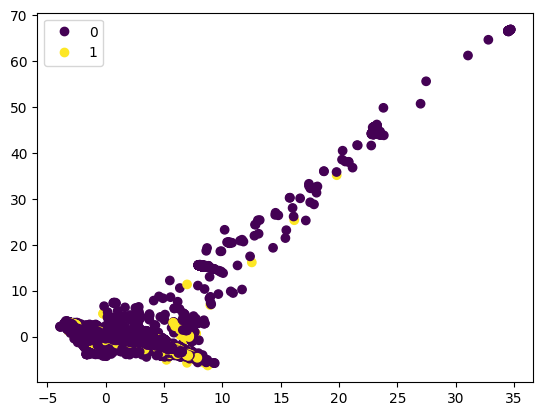

In [57]:
def display_pca(df, num_features, label_col):
    X, y = df.iloc[:,:num_features], df[label_col]
    from sklearn.decomposition import PCA
    pca = PCA()
    Xt = pca.fit_transform(X)
    plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
    plt.legend(handles=plot.legend_elements()[0], labels=[0,1])
    plt.show()

display_pca(pos_neg_dropna, num_features=60, label_col="target")

In [58]:
pos_neg_dropna.to_csv(fp_downsampled_dropna_file)